# Exercise 06: Ising model
<b> Complete the NSL_simulator code to simulate a 1D Ising model with the Gibbs sampling algorithm (the Metropolis algorithm is already implemented) to sample the Boltzmann's weight $p(\{ s_i \}) = \exp(-\beta H)/Z$. Verify the possibility to restart from a previous spin configuration.
The code already computes the internal energy: $U(N,T) = \langle H \rangle$. Add the calculation of $C(N,T)$, $\chi(N,T)$, $M(N,T,h)$ and compute:<b>
1. $U(N,T) = \langle H \rangle_{h=0}$
2. $C(N,T) = k_B \beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)$ 
3. $\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$
4. $M(N,T,h=0.02)= \langle \sum_{i=1,N}s_i \rangle_{h=0.02}$

<b>as a function of $T$ in the range $\left[0.5;2.0\right]$ for a system of $N=50$ spins with $J=1$.
As usual, use data blocking and give an estimate of the statistical uncertainties.<b>

The initial configuration is an Ising system composed of 50 particles, 50% with spin 1/2 and the other 50% with spin -1/2. The exercise consisted in measuring the system properties using two different Montecarlo methods: the Metropolis algorithm and the Gibbs algorithm. The Metropolis was already included in the simulator, and it works by computing an acceptance probability at every step, and then trying to flip every spin according to this probability. The acceptance probability corresponds to the Boltzmann weight for particle i:
$\exp \left( -\beta \Delta E\right)$ with $\Delta E = 2Js_i (s_{i+1}+s_{i-1}) $ considering only its closest neighbors.
Meanwhile in the Gibbs algorithm all of the moves are accepted, but there is a different probability of obtaining a certain value of spin for each particle, and the spins are assigned accordingly. This is how I implemented the Gibbs algorithm:
```c++
  if(_sim_type == 3){ //Gibbs sampler for Ising
   double  delta_E = 2.0 * 
                 ( _J * (_particle(this->pbc(i-1)).getspin() + _particle(this->pbc(i+1)).getspin() ) + _H ); 
  double p = 1./(1.+exp(-_beta*delta_E)); //probability to have spin up
  double r = _rnd.Rannyu();
  if (r<p) _particle(i).setspin(1);
  else _particle(i).setspin(-1);
    }

For every property I will briefly explain how I implemented the code for the measurement, and show the results obtained using Metropolis and Gibbs algorithm compared with the model, along with their respective errors and the difference between the two algorithms. All the properties have been measured with the following system configuration, expect for the magnetization in which h was set to 0,02.

```
SIMULATION_TYPE        2/3    1.0    0.0/0.02
RESTART                0
TEMP                   2.0
NPART                  50
RHO                    1.0
R_CUT                  0.0
DELTA                  0.0
NBLOCKS                20
NSTEPS                 20000

### INTERNAL ENERGY
$$\frac{U(N,T)}{N} = \frac{\langle H \rangle}{N}
= \frac{1}{N} \sum_{\{ s_i \}} H \frac{\exp \left( -\beta H\right)}{Z}$$ 

The internal energy computation was already included in the code, and it is computed  by summing over the values of $\Delta E$, defined as I explained before, for all of the particles. 

In [2]:
import numpy as np

#model parameters
points=100
T = np.linspace(0.45,2.2,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
def plot_property(file_metro,file_gibbs,model,prop_string):

    file_path= "/home/elisa/Scrivania/LSN/LSN/nsl_simulator/NSL_SIMULATOR/OUTPUT/"
    df = pd.read_csv(file_path+file_metro,sep ="\t",skiprows=1, names = ['TEMPERATURE','AVE','ERROR'])
    dfG = pd.read_csv(file_path+file_gibbs,sep ="\t",skiprows=1, names = ['TEMPERATURE','AVE','ERROR'])

    
    fig, axes = plt.subplots(1,3,figsize=(14,4))
    axes[0].plot(T, model, label ='Model',color ='black',linestyle = 'dashed')
    axes[0].set_xlabel('T')
    axes[0].set_ylabel(prop_string)
    axes[0].errorbar(df['TEMPERATURE'],df['AVE'], yerr = df["ERROR"],marker = '.', label= 'Metropolis',color = 'darkblue',alpha=0.7)
    axes[0].errorbar(dfG['TEMPERATURE'],dfG['AVE'],yerr = dfG["ERROR"],marker = '.', label = 'Gibbs',color = 'orange',alpha =0.7)
    axes[0].legend()
    axes[0].grid()
    axes[0].set_title ('Results')

    axes[1].plot(df['TEMPERATURE'],df['ERROR'],marker = '.', label= 'Metropolis error',color = 'darkblue',alpha=0.7)
    axes[1].plot(dfG['TEMPERATURE'],dfG['ERROR'],marker = '.', label= 'Gibbs error',color = 'orange',alpha=0.7)
    axes[1].legend()
    axes[1].grid()
    axes[1].set_title('Errors')

    axes[2].plot(df['TEMPERATURE'],df['AVE']-dfG['AVE'],marker = '.', label= 'Metropolis',color = 'seagreen',alpha=0.7)
    axes[2].hlines(0,0.5,2.0,color = 'black')
    axes[2].grid()
    axes[2].set_title('Difference between algorithms')
    
    plt.suptitle('Ising model internal energy')
    plt.show()

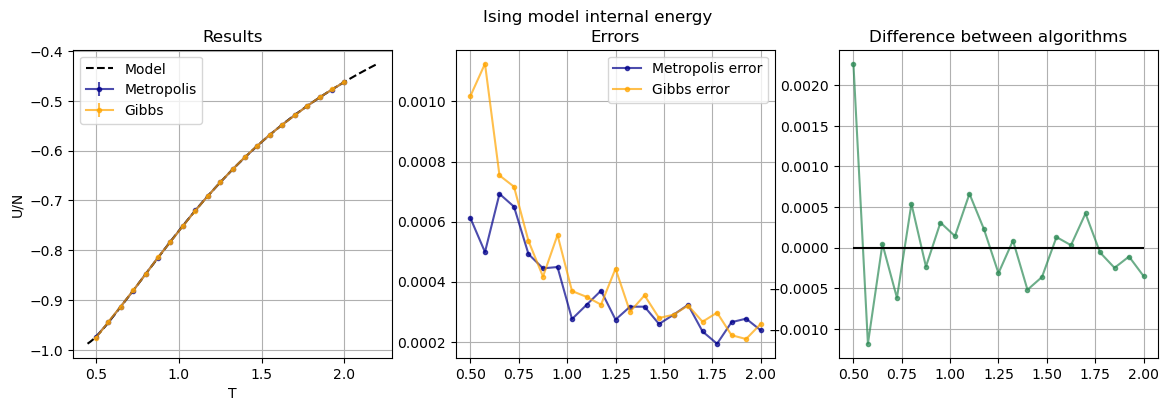

In [12]:
file_metro = 'InternalEnergy_metro.csv'
file_gibbs = 'InternalEnergy_Gibbs.csv'
e = -J*( th + ch*thN )/( 1 + thN ) #model

plot_property(file_metro,file_gibbs,e,'U/N')

### HEAT CAPACITY
$C(N,T) = k_B \beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)$ 

For the heat capacity measurement I reserved two indices of the meausurement vector, one in which I stored H and in the other one I stored $H^2$. in this way I was able to measure the two mean values separately, and then in the *averages()* function I computed the full values of cv by subtracting the contents of the indices.

**in measure():**
```c++
if (_measure_cv){
  if (_sim_type < 2) cerr<<"Susceptibility measurement is only possible for Ising simulations";
    else { 
        double s_i, s_j;
      for (int i=0; i<_npart; i++){
        s_i = double(_particle(i).getspin());
        s_j = double(_particle(this->pbc(i+1)).getspin());
        double H = - _J * s_i * s_j - 0.5 * _H * (s_i + s_j);
        cv_temp += H;
      }
      _measurement(_index_cv) = cv_temp;
      _measurement(_index_cv+1) = cv_temp*cv_temp;
    }



**in averages():**
``` c++
 _average     = _block_av / double(_nsteps); 
  double cv_ave = _beta*_beta*(_average[_index_cv+1]-pow(_average[_index_cv],2))/(_npart);
  _average[_index_cv]=cv_ave;

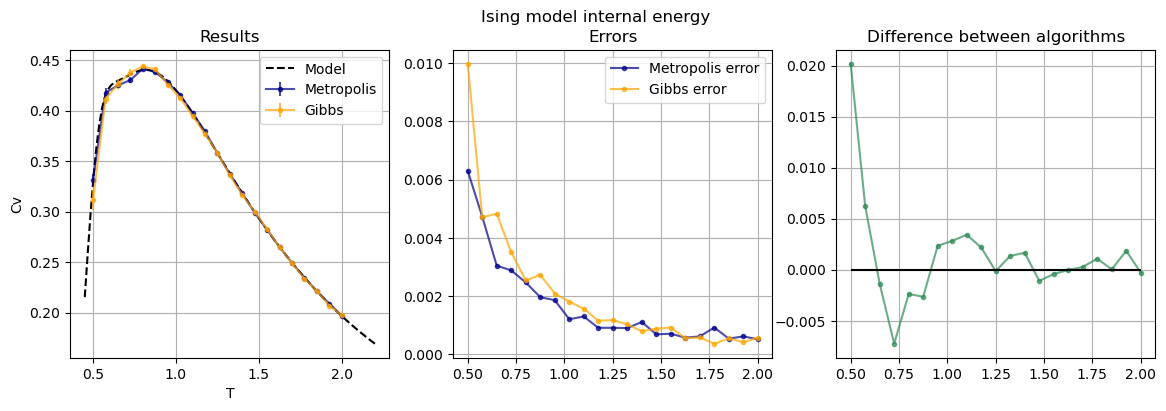

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
file_metro ="CV_metro.csv"

file_gibbs="CV_Gibbs.csv"

heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2) #model
plot_property(file_metro,file_gibbs,heat,'Cv')


### SUSCEPTIBILITY
$\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$

I added the susceptibility measurement by simply summing all of the particles spins:
```c++
 if (_measure_chi){
    if (_sim_type < 2) cerr<<"Susceptibility measurement is only possible for Ising simulations";
    else { 
      double s_i;
      for (int i=0; i<_npart; i++){
        s_i = double(_particle(i).getspin());
        chi_temp += s_i;
      }
      chi_temp = _beta*(chi_temp * chi_temp);
      _measurement(_index_chi) = chi_temp/_npart;
    }

  }

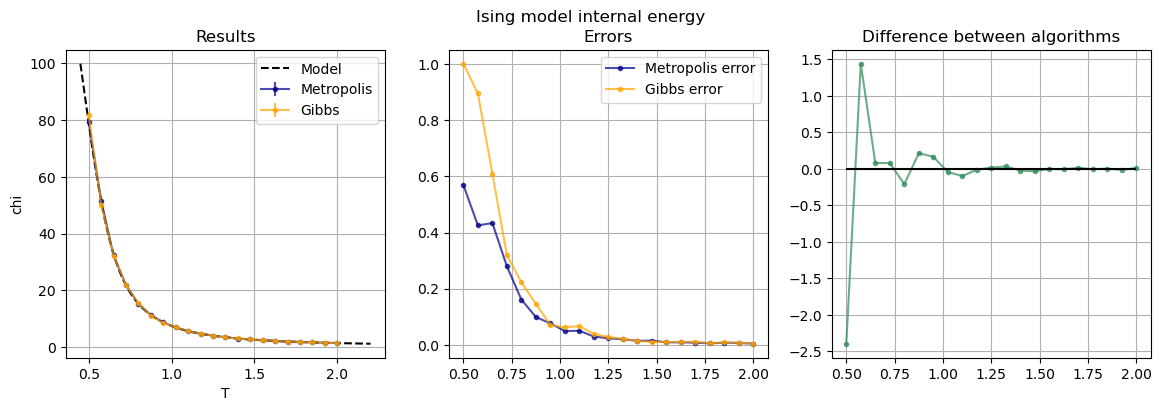

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
file_metro ="Chi_metro.csv"

file_gibbs = "Chi_Gibbs.csv"

X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN) #model
plot_property(file_metro,file_gibbs,X,'chi')


### MAGNETIZATION
$M(N,T,h=0.02)= \langle \sum_{i=1,N}s_i \rangle_{h=0.02}$

To measure the magnetization I performed a separate simulation in which I set the external field to h=0.02, and only measured this property in the fowollowing way:

```c++
   if (_measure_magnet){
    if (_sim_type < 2) cerr<<"Susceptibility measurement is only possible for Ising simulations";
    else { 
      double s_i;
      for (int i=0; i<_npart; i++){
        s_i = double(_particle(i).getspin());
        magn_temp += s_i;
      }
      magn_temp/=_npart;
      _measurement(_index_magnet) = magn_temp;
    }

  }

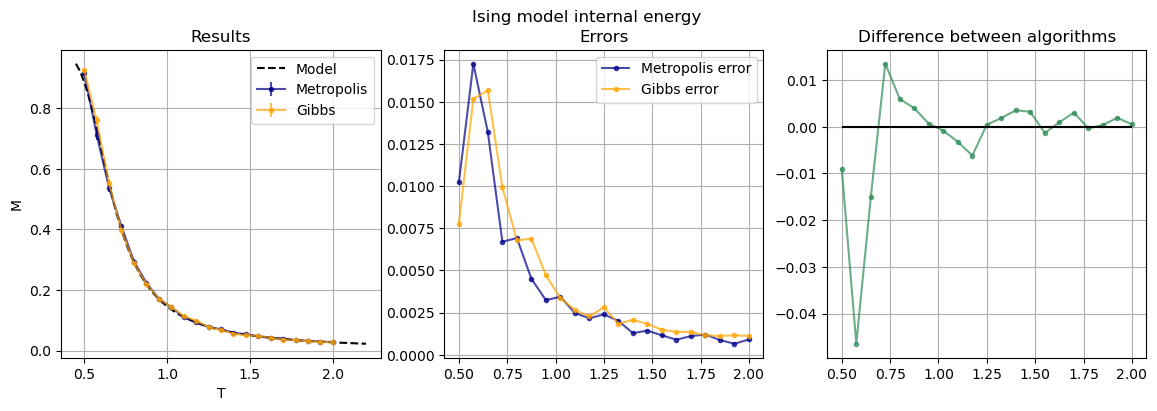

In [9]:

h=0.02 #external field
b = 1/T

l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
Z = l1**Ns + l2**Ns
M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)

file_metro= "Magnetization_metro.csv"
file_gibbs= "Magnetization_Gibbs.csv"
plot_property(file_metro,file_gibbs,M,'M')
